# Approach 2 - Using finetuned DiT model for RVL-CDIP
Implementation based on the paper[ DiT: Self-supervised Pre-training for
Document Image Transformer](https://arxiv.org/pdf/2203.02378v3.pdf) \\
Advantages of this model: \\
 - OCR-Free model so lesser dependencies
 - Easy to train
 - Converges very quickly and achieves good accuracy quicker than other models


In [ ]:
model_checkpoint = "microsoft/dit-base-finetuned-rvlcdip" # pre-trained model from which to fine-tune. Using model pre-trained on the bigger version of the RVL-CDIP dataset. Using base model as it has an accuracy of 92.11% at just 87M parameters.
batch_size = 4

Install the `datasets`,`transformers`, and `accelerate` libraries.
Accelerate is important as this notebook utilizes some features of huggingfaces.


In [ ]:
!pip install -q datasets transformers
!pip install accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 4.2 MB/s eta 0:00:00


## Useful in creating a huggingfaces repo as it creates model cards automatically and also sets up an instant inferencing API on the repo

In [ ]:
from huggingface_hub import notebook_login

notebook_login()


Installing Git-LFS to upload model checkpoints:

In [ ]:
%%capture
!sudo apt -qq install git-lfs
!git config --global credential.helper store

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Fine-tuning a model on an image classification task

### Loading the dataset


Loading the custom dataset using `data_dir` argument to initialize a dataset.

In [ ]:
from datasets import load_dataset

dataset = load_dataset("imagefolder", data_dir="/content/drive/MyDrive/rvl_cdip_1000_samples/images")

Resolving data files:   0%|          | 0/1000 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Let us also load the Accuracy metric, which we'll use to evaluate our model both during and after training.

In [ ]:
from datasets import load_metric

metric = load_metric("accuracy")

<ipython-input-9-350fcae91df9>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


The `dataset` object itself is a [`DatasetDict`](https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasetdict), which contains one key per split (in this case, only "train" for a training split).

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 1000
    })
})

To access an actual element, you need to select a split first, then give an index:

In [ ]:
example = dataset["train"][6]
example

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=778x1000>,
 'label': 0}

Each example consists of an image and a corresponding label. We can also verify this by checking the features of the dataset:

In [ ]:
dataset["train"].features

{'image': Image(decode=True, id=None),
 'label': ClassLabel(names=['0', '1', '10', '11', '12', '13', '14', '15', '2', '3', '4', '5', '6', '7', '8', '9'], id=None)}

The cool thing is that we can directly view the image (as the 'image' field is an [Image feature](https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasets.Image)), as follows:

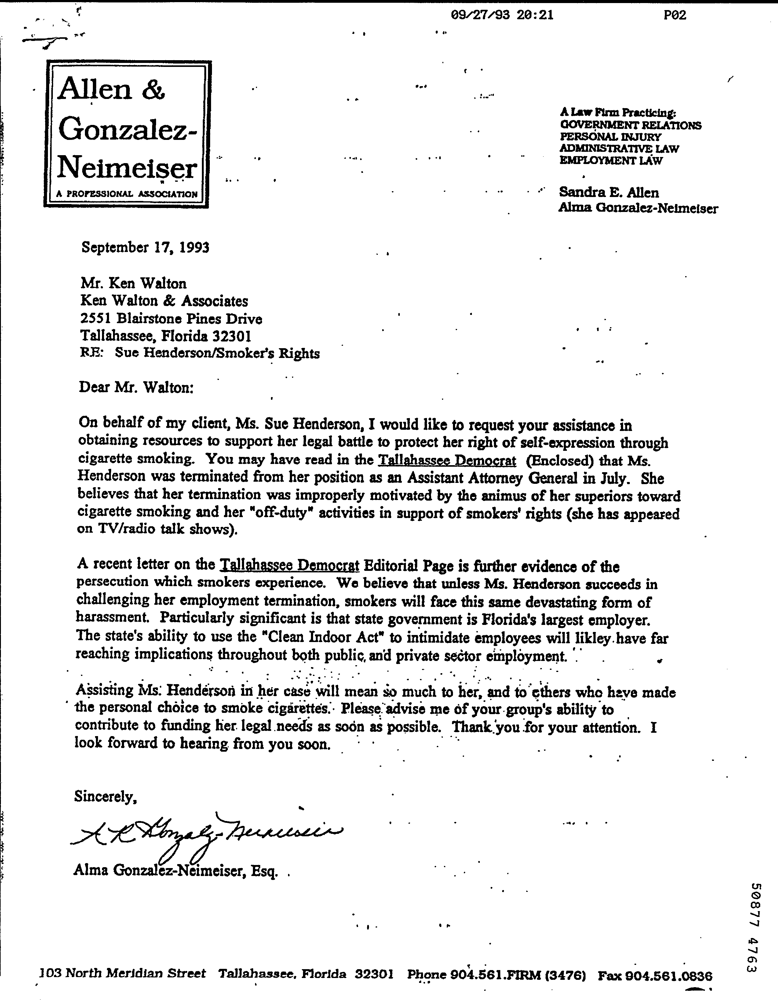

In [ ]:
example['image']

Let's print the corresponding label:

In [ ]:
example['label']

0

As you can see, the `label` field is not an actual string label. By default the `ClassLabel` fields are encoded into integers for convenience:

In [ ]:
dataset["train"].features["label"]

ClassLabel(names=['0', '1', '10', '11', '12', '13', '14', '15', '2', '3', '4', '5', '6', '7', '8', '9'], id=None)

Let's create an `id2label` dictionary to decode them back to strings and see what they are. The inverse `label2id` will be useful too, when we load the model later.

In [ ]:
labels = dataset["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

id2label[2]

'10'

### Preprocessing the data

Before we can feed these images to our model, we need to preprocess them.

Preprocessing images typically comes down to (1) resizing them to a particular size (2) normalizing the color channels (R,G,B) using a mean and standard deviation. These are referred to as **image transformations**.

In addition, one typically performs what is called **data augmentation** during training (like random cropping and flipping) to make the model more robust and achieve higher accuracy. Data augmentation is also a great technique to increase the size of the training data.

We will use `torchvision.transforms` for the image transformations/data augmentation

Since the base-model accepts only 224x224 images we resize to the appropriate size of the model, and use the appropriate image mean and standard deviation for the model architecture we are going to use, and we instantiate what is called an image processor with the `AutoImageProcessor.from_pretrained` method.


This image processor is a minimal preprocessor that can be used to prepare images for inference.
## As DIT and BeIT share the same architecture, the AutoImageProcessor uses the default BeIT's default ImageProcessor.
Source: https://huggingface.co/docs/transformers/model_doc/dit \\

In [ ]:
from transformers import AutoImageProcessor

image_processor  = AutoImageProcessor.from_pretrained("microsoft/dit-base-finetuned-rvlcdip")
image_processor

preprocessor_config.json:   0%|          | 0.00/302 [00:00<?, ?B/s]

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
/usr/local/lib/python3.10/dist-packages/transformers/models/beit/image_processing_beit.py:110: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


BeitImageProcessor {
  "crop_size": {
    "height": 224,
    "width": 224
  },
  "do_center_crop": false,
  "do_normalize": true,
  "do_reduce_labels": false,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "BeitImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}



 ## Here we define 2 separate functions, one for training (which includes data augmentation) and one for validation (which only includes resizing, center cropping and normalizing).

In [ ]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
if "height" in image_processor.size:
    # size = (image_processor.size["height"], image_processor.size["width"])
    size = (image_processor.size["height"], image_processor.size["width"]) #224 can potentially reduce size of important features so using 60% rescale factor on approx image
    crop_size = size
    max_size = None
elif "shortest_edge" in image_processor.size:
    size = image_processor.size["shortest_edge"]
    crop_size = (size, size)
    max_size = image_processor.size.get("longest_edge")

train_transforms = Compose(
        [
            RandomResizedCrop(crop_size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

val_transforms = Compose(
        [
            Resize(size),
            CenterCrop(crop_size),
            ToTensor(),
            normalize,
        ]
    )

def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

Next, we can preprocess our dataset by applying these functions. We will use `set_transform` which allows to apply the functions above on the images and then we proceed to split the dataset into a 90-10 split.

In [ ]:
# split up training into training + validation
splits = dataset["train"].train_test_split(test_size=0.1)
train_ds = splits['train']
val_ds = splits['test']

In [ ]:
train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)

Let's access an element to see that we've added a "pixel_values" feature:

In [ ]:
train_ds[0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=777x1000>,
 'label': 15,
 'pixel_values': tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],
 
         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],
 
         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]])}

### Training the model

For classification we use the `AutoModelForImageClassification` class. Calling the `from_pretrained` method on it will download the weights for us. As the label ids and the number of labels are dataset dependent, we pass `label2id`, and `id2label` alongside the `model_checkpoint` here. This will make sure a custom classification head will be created (with a custom number of output neurons as per the number of classes).


In [ ]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

model = AutoModelForImageClassification.from_pretrained(
    model_checkpoint,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes = True, # doesnt matter as the base model is also based rvl cdip dataset so num of classes would be the same
)


config.json:   0%|          | 0.00/1.79k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/343M [00:00<?, ?B/s]

To instantiate a `Trainer`, we will need to define the training configuration and the evaluation metric like the [`TrainingArguments`](https://huggingface.co/transformers/main_classes/trainer.html#transformers.TrainingArguments), which is a class that contains all the attributes to customize the training. It requires one folder name, which will be used to save the checkpoints of the model.

Most of the training arguments are pretty self-explanatory, but one that is quite important here is `remove_unused_columns=False`. This one will drop any features not used by the model's call function. By default it's `True` because usually it's ideal to drop unused feature columns, making it easier to unpack inputs into the model's call function. But, in our case, we need the unused features ('image' in particular) in order to create 'pixel_values'.

In [ ]:
import accelerate
import transformers

transformers.__version__, accelerate.__version__

('4.35.2', '0.25.0')

In [ ]:
!pip uninstall accelerate transformers

In [ ]:
model_name = model_checkpoint.split("/")[-1]
args = TrainingArguments(
    f"{model_name}-RVLCDIP",
    remove_unused_columns=False,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=True,
)

Here we set the evaluation to be done at the end of each epoch, tweak the learning rate, use the `batch_size` defined at the top of the notebook and customize the number of epochs for training. Since the best model might not be the one at the end of training, we ask the `Trainer` to load the best model it saved (according to `metric_name`) at the end of training.

The last argument `push_to_hub` allows the Trainer to push the model to the [Hub](https://huggingface.co/models) regularly during training which would be super useful if one is one google colab as it can be unstable at times.

Next, we need to define a function for how to compute the metrics from the predictions, which will just use the `metric` we loaded earlier. The only preprocessing we have to do is to take the argmax of our predicted logits:

In [ ]:
import numpy as np

# the compute_metrics function takes a Named Tuple as input:
# predictions, which are the logits of the model as Numpy arrays,
# and label_ids, which are the ground-truth labels as Numpy arrays.
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

We also define a `collate_fn`, which will be used to batch examples together.
Each batch consists of 2 keys, namely `pixel_values` and `labels`.

In [ ]:
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

Then we just need to pass all of this along with our datasets to the `Trainer`:

In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

You might wonder why we pass along the `image_processor` as a tokenizer when we already preprocessed our data. This is only to make sure the image processor configuration file (stored as JSON) will also be uploaded to the repo on the hub.

Now we can finetune our model by calling the `train` method:

In [ ]:
train_results = trainer.train()
print(train_results)
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

Epoch,Training Loss,Validation Loss,Accuracy
0,0.033600,0.676561,0.860000
1,0.088800,0.813176,0.830000
2,0.110800,0.775540,0.830000


TrainOutput(global_step=168, training_loss=0.07231934262173516, metrics={'train_runtime': 116.6582, 'train_samples_per_second': 23.145, 'train_steps_per_second': 1.44, 'total_flos': 2.083469786968228e+17, 'train_loss': 0.07231934262173516, 'epoch': 2.99})
***** train metrics *****
  epoch                    =        2.99
  total_flos               = 194038244GF
  train_loss               =      0.0723
  train_runtime            =  0:01:56.65
  train_samples_per_second =      23.145
  train_steps_per_second   =        1.44


We can check with the `evaluate` method that our `Trainer` did reload the best model properly (if it was not the last one):

In [ ]:
metrics = trainer.evaluate()
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =       2.99
  eval_accuracy           =       0.86
  eval_loss               =     0.6766
  eval_runtime            = 0:00:03.76
  eval_samples_per_second =     26.565
  eval_steps_per_second   =      6.641


In [ ]:
trainer.push_to_hub()

events.out.tfevents.1701606643.55aeeac92c83.358.8:   0%|          | 0.00/411 [00:00<?, ?B/s]

'https://huggingface.co/imPdhar/dit-base-finetuned-rvlcdip-raft-RVLCDIP/tree/main/'

## Inference

For inference we try to run a random photo of an advertisement we got.

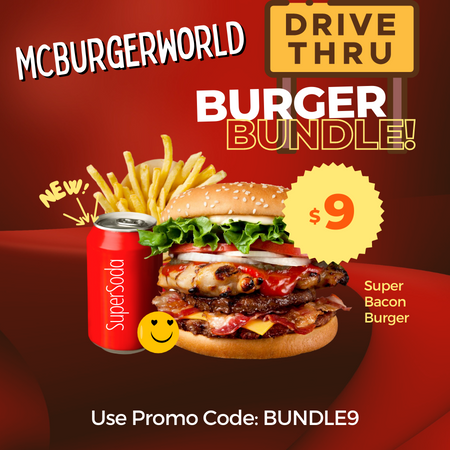

In [ ]:
from PIL import Image
import requests

url = 'https://study.com/cimages/multimages/16/burgerad15179945781952220614.png' #For URL based inferencing
image = Image.open(requests.get(url, stream=True).raw)
# image = Image.open('/content/image_0001.png') #Local image based inferencing
image

We'll load the image processor and model from the hub (here, we use the [Auto Classes](https://huggingface.co/docs/transformers/model_doc/auto#transformers.AutoModelForImageClassification), which will make sure the appropriate classes will be loaded automatically based on the `config.json` and `preprocessor_config.json` files of the repo on the hub):

In [ ]:
from transformers import AutoModelForImageClassification, AutoImageProcessor

repo_name = "imPdhar/dit-base-finetuned-rvlcdip-RVLCDIP" #Stored conveniently on a private hf repo

image_processor = AutoImageProcessor.from_pretrained(repo_name)
model = AutoModelForImageClassification.from_pretrained(repo_name)

In [ ]:
encoding = image_processor(image.convert("RGB"), return_tensors="pt") #Convert image to RGB and return tensors in Pytorch format
print(encoding.pixel_values.shape)

torch.Size([1, 3, 224, 224])


In [ ]:
import torch

# forward pass
with torch.no_grad():
    outputs = model(**encoding)
    logits = outputs.logits

By using that as an input and by forward passing into the model without updating the gradients, we get the predictions, here which is right.

In [ ]:
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])


Predicted class: 4


### As we can see, category 4 is advertisements as given in the dataset and the uploaded image was an advertisement too!


### Below is the same image inferenced on a pre-trained model from huggingfaces(not the one we trained)

Inference Example:  https://huggingface.co/microsoft/dit-base-finetuned-rvlcdip  

In [ ]:
from transformers import AutoImageProcessor, AutoModelForImageClassification
import torch
from PIL import Image

image = Image.open('/content/advertisement01.png').convert('RGB')

processor = AutoImageProcessor.from_pretrained("microsoft/dit-base-finetuned-rvlcdip")
print(processor)
model = AutoModelForImageClassification.from_pretrained("microsoft/dit-base-finetuned-rvlcdip")

inputs = processor(images=image, return_tensors="pt")
outputs = model(**inputs)
logits = outputs.logits

# model predicts one of the 16 RVL-CDIP classes
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

preprocessor_config.json:   0%|          | 0.00/302 [00:00<?, ?B/s]

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
/usr/local/lib/python3.10/dist-packages/transformers/models/beit/image_processing_beit.py:110: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


BeitImageProcessor {
  "crop_size": {
    "height": 224,
    "width": 224
  },
  "do_center_crop": false,
  "do_normalize": true,
  "do_reduce_labels": false,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "BeitImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}



config.json:   0%|          | 0.00/1.79k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/343M [00:00<?, ?B/s]

Predicted class: advertisement
